In [2]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
from IPython.display import display, Markdown
az.style.use('arviz-darkgrid')
np.random.seed(44)


WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams.update({
    "figure.figsize": [12.0, 5.0],
    'figure.facecolor': '#fffff8',
    'axes.facecolor': '#fffff8',
    'figure.constrained_layout.use': True,
    'font.size': 14.0,
    'hist.bins': 'auto',
    'lines.linewidth': 3.0,
    'lines.markeredgewidth': 2.0,
    'lines.markerfacecolor': 'none',
    'lines.markersize': 8.0, 
})

# Probabilistic programming


Giorgio Corani <br/>
*Bayesian Data Analysis and Probabilistic Programming*
<br/>
<br/>
``giorgio.corani@supsi.ch``





# Probabilistic programming


* Bayesian statistics updates the prior given the data via Bayes' theorem. 

* The variables  we cannot observe are *parameters*;  e.g.,   $\theta$ in the coin example. 

* We assign priors to the parameters. 

* Yet  if prior and likelihood are not conjugate  the posterior is  untractable, in which case it has to be numerically sampled. Designing an appropriate sampling algorithm requires mathematical and numerical expertise.

* Languages for *probabilistic programming* address this problem.

* They describe a probabilistic model in  few lines and  compute the posterior of the parameters (*inference*) automatically. 

# Probabilistic programming languages


* We  use PyMC3, a package for probabilistic programming under Python.

* You also the arviz package, which provides functions to analyze the posterior. 
    * Please install the latest version: `pip install arviz==0.12.1`


* Another important language for probabilistic programming is [Stan](https://mc-stan.org/). This can be used to implement a custom model, or via the R packages ( [brms](https://cran.r-project.org/web/packages/brms/index.html) and  [rstanarm](https://mc-stan.org/rstanarm/))  which provide some pre-implemented models and various high-level functionationalities.

# Estimating the bias of the coin with PyMC3


* We start by generating   data with a known $\theta$ so that we can check the accuracy of our estimate.

In [4]:
#Generating the data
np.random.seed(123)
n_draws = 42
theta_real = .35  

#we generate the data (rvs stands for random-variates)
data = stats.bernoulli.rvs(p=theta_real, size=n_draws)

#number of successes
y = np.sum(data)


# the data are instead a vector of 0s and 1s.
data

array([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0])

# The beta-binomial model

* We consider  a flat prior for $\theta$:  Beta(1,1). 
* We thus assume in this case all the values of $\theta$ to be equally probable a priori.
* The likelihood is binomial; $y$ is the number of heads. 

\begin{align}
\theta &\sim \operatorname{Beta}(\alpha=1, \beta=1)\\
y &\sim \operatorname{Bin}(n=n_{\text{draws}}
, p=\theta)
\end{align}

In [5]:
# Beta-binomial model in Pymc3


# the lines within the "with" statement refer to the same model 
with pm.Model() as beta_binomial_model:
    # MODEL DEFINITION
    #The first argument is  a string specifying the name of the random variable. 
    #We recommend matching the name of the Python variable.
    #Uniform prior, i.e., Beta(1,1) 
    theta = pm.Beta('theta', alpha=1, beta=1)  
    
    #Likelihood, characterized by the keyword  `observed`.
    y = pm.Binomial("y", p=theta, observed=sum(data), n=n_draws)

# Inference


* The numerical sampling of the posterior samples is called *inference*. 
* We perform inference about the parameters, i.e., the unobserved variables to which we assigned a prior.
* In this case we make inference about $\theta$.


In [6]:
# Sampling the posterior

with beta_binomial_model:
    #the language automatically defines an appropriate sampling strategy
    trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/scalar/basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0) / x
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/tensor/elemwise.py:826: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/scalar/basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
/Users/giorgiocorani/opt/anaconda3/envs/bda/lib/python3.9/site-packages/theano/scalar/basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
/Users/giorgiocorani/opt/anaconda3/envs/


*  PyMC3 uses  NUTS,  a state-of-the-art sampler for continuous variables.

* The third line indicates how many chains in parallel are computed by PyMC3 (default:4).

* The last line is a progress bar with various metrics.

# Diagnosing  the chains 

<img src='img/trace-burn.png' width=400 align="center" >

* The values in the chain must be *representative* of the posterior distribution. 
* They should not be  influenced by the arbitrary initial value of the chain.
 > Credits: this figure and figures in the following slides are from Krushke (Chap 7.5)

# Diagnosing  the chains

<img src='img/trace-burn.png' width=400 align="center" >

* It takes a few hundred steps for the three chains to converge to the same region of the parameter.
* The first several hundred steps (*burn-in*) of the chain should be discarded as they are not representative.

# Removing the burn-in period
<img src="img/trace-convergence.png" width=500 >

* PyMC3 automatically removes the burn-in period.
* Once removed the burn-in period,   the three chains meander  smoothly and overlap each other (*good mixing*).
* The trace should look like white noise.



# Checking the  density plots


<img src='img/kde-no-convergence.png' width=500 >

* We compute a density plot on the samples from each chain.

* The density plots of the three chains do not overlap  well during the burn-in period: the chains have not converged.

# Density plots which overlap well 


<img src='img/kde-convergence.png' width=500 >

* This suggests that the chains contain representative values from the posterior distribution. 
* The HDI limits are slightly different for each chain because each chain is a finite random sample. 

# Poor mixing
<img src='img/chain-poor-mixing.png' width=500 style="display=block; margin:auto"/>

* The blue chain got stuck: it is a horizontal line for long number of samples.
* This is a problem: the sampler is only accepting  proposals in the very close neighborhood.
* It is thus sampling very slowly;  in  finite samples this prevents sampling the entire posterior,  biasing  the results.

## Plotting the posterior with Arviz

* ArviZ is a Python package which analyzes the PyMC3 trace.
* After sampling we evaluate  the results through ArviZ's `plot_trace` function.
* The `trace` contains  the sampled values of the unobserved variables, called *parameters*. In this case,  $\theta$ is the only parameter.
* Note that the data `y` are an observed variable, and hence known. 


## Plotting the posterior with `plot_trace`

We get two plots for the variable $\theta$:

* on the  left we have a density plot (KDE, Kernel Density Estimation)

* on the right we have the trace (the values sampled at each step).

* In the following plot we see  the chains mix well  and that the density plot are smooth and overlap.


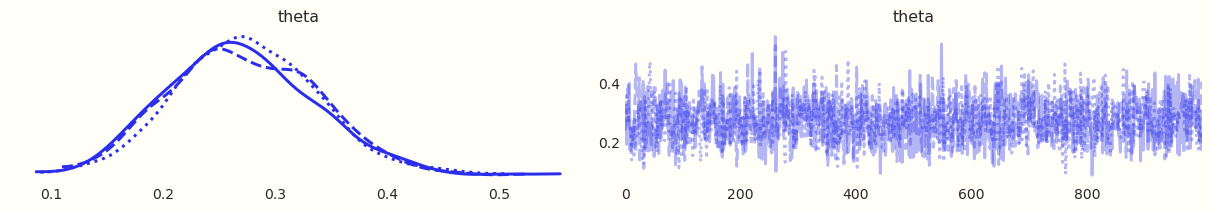

In [21]:
import arviz as az
az.plot_trace(trace);

# Effective sample size (ESS)

* The chains might be auto-correlated, i.e.,  the value samples at the current iteration is similar to the value sampled in the previous iteration.
* How much independent information is in the chains ?
* What would be the sample size of a completely non-autocorrelated chain that yielded the same information?
* This is measured by the ESS.
* The ESS estimates how many independent draws contain the same amount of information as the dependent sample obtained by MCMC sampling.


# ESS with high auto-correlation

<img src='img/ess-low.png' width=1000 >

# ESS with low auto-correlation

<img src='img/ess-high.png' width=1000 align="center" >

# Effective sample size (ESS)

*  The effective sample size divides the actual sample size by the amount of autocorrelation in the chain.

\begin{align}
\text{ESS}= \frac{N}{(1 + 2\sum_{k=1}^{k=\infty} ACF(k))}
\end{align}

where
$$
ACF(k)  = \operatorname{Cor}(\theta_t, \theta_{t+k})
$$

# Bulk and Tail Effective Sample Size

* The *Bulk Effective Sample Size* (ess_bulk) is a useful measure for sampling efficiency in the bulk of the distribution (related e.g. to efficiency of mean and median estimates).

* The *Tail Effective Sample Size* (ess_tail) estimates  the effective sample sizes for 5% and 95% quantiles; it is thus a useful measure of sampling efficiency in the tails of the distribution 

* Both  should be at least  (approximately) 400,  in order to have be reliable  estimates of the related posterior quantiles. 

# Rhat (the Gelman-Rubin statistic)

* R-Hat  is roughly  the ratio of between-chain variance to within-chain variance. 
* This diagnostic uses multiple chains to check for lack of convergence, and is based on the notion that if multiple chains have converged, by definition they should appear very similar to one another; if not, one or more of the chains has failed to converge.
* Rhat thus compares the variance between chains with the variance within chains.  Ideally, Rhat = 1.
* It is ok if Rhat < 1.1; higher values signal a lack of convergence.

<img src='img/rhat-example.png' width=700 align="center" >

# Summarizing the posterior

The `az.summary` function show different information about  $\theta$:
* the mean, the standard deviation and the  HDI (whose desired coverage can be set via 'hdi_prob') 
* the effective number of samples for bult and tail
* the *r_hat* statistic

In [24]:
az.summary(trace, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.272,0.065,0.155,0.407,0.002,0.001,1339.0,2140.0,1.0


# Comment

Our sample is very good:

* the chains mix well
* rhat is close to 1
* both ess are high

We can analyze the posterior to draw some conclusions.




# Reporting the posterior 

The `plot_posterior` function provides a visual summary of the posterior:
*  the density plot
* the mean of the distribution (we can have  the median or mode using the `point_estimate` argument) 
* the 95% HPD, whose coverage can be set the `alpha` argument. 

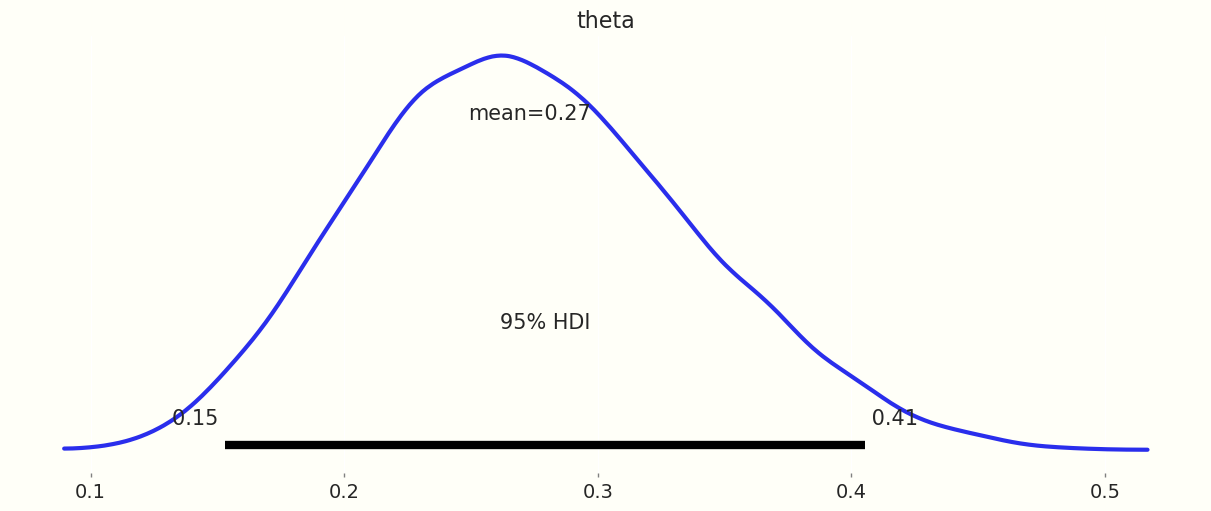

In [7]:
az.plot_posterior (trace, hdi_prob = 0.95);

## Decisions based on posterior

* Assume  we have to decide whether or not the coin is biased, i.e., if it lands heads with probability different from 0.5. 

* We thus check whether the reference value 0.5 (i.e., the unbiased coin) is within  the HDI interval. 

* The 95% HDI interval goes from $\approx$ 0.16 to $\approx$ 0.41,  excluding 0.5. It rules out  the hypothesis of the coin being unbiased.

# ROPE

* The probability of the *exact* value $\theta$=0.5 is zero, since $\theta$ is a continous variables (recall that you need to integrate the pdf over an interval in order to obtain a probability).


*  Generally we are not interested in precision; rather,  we are interested in the probability of $\theta$ lying in a close interval around 0.5, which means that the coin is  *practically* unbiased.


* We thus  define a _region of practical equivalence_  (ROPE). 


* For instance we might  consider that  any value of $\theta$ between 0.49 and 0.51 is  practically unbiased. 


* The  definition of the ROPE is subjective and relies on domain knowledge. 

# ROPE 

> A ROPE is an arbitrary interval that is determined using prior and relevant knowledge about a topic. Any value within this range is considered equivalent.

* Once the ROPE is established, we can use the following rules to make a decision


# ROPE

* A value  is  *rejected*  if the  ROPE does not overlap with the  HDI (usually we consider the 95% HDI).

 * ROPE = [0.49, 0.51]
 
 * the HDI  [0.40-0.45] rejects the hypothesis of *practical* unbiasedness.
 

* The value of a parameter is *accepted* if the HDI contains the  ROPE.

 * ROPE = [0.49, 0.51]
 
 * the HDI [0.48 -0.52] accepts the hypothesis of *practical* unbiasedness.


* Other cases cannot be decided in a strong fashion, and might require collecting furher data.



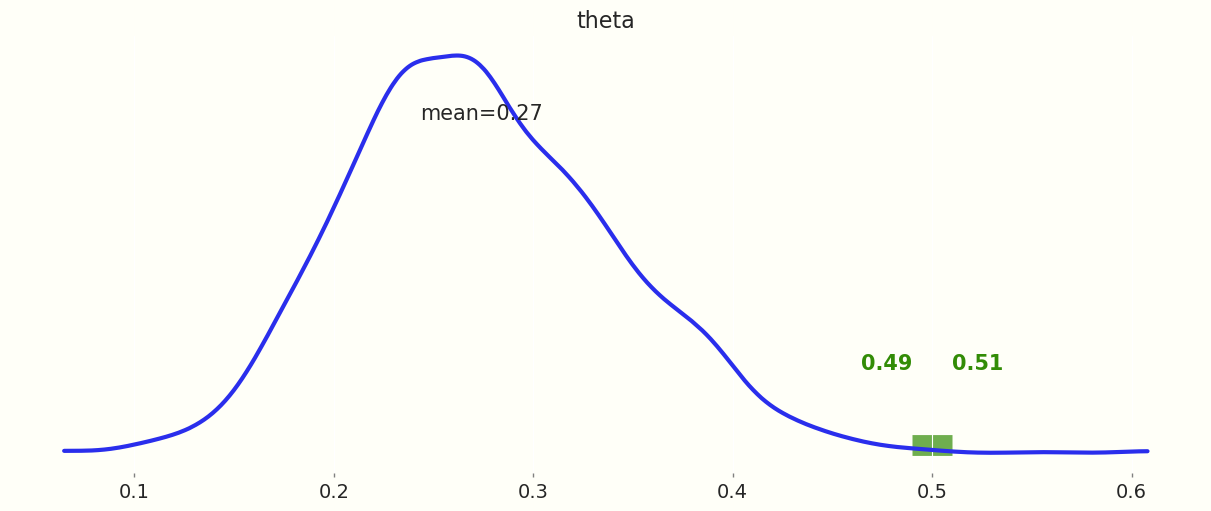

In [7]:
# Using ArviZ's `plot_posterior` function, we can plot both HDI and ROPE.
az.plot_posterior (trace, rope = [0.49, 0.51], hdi_prob='hide');

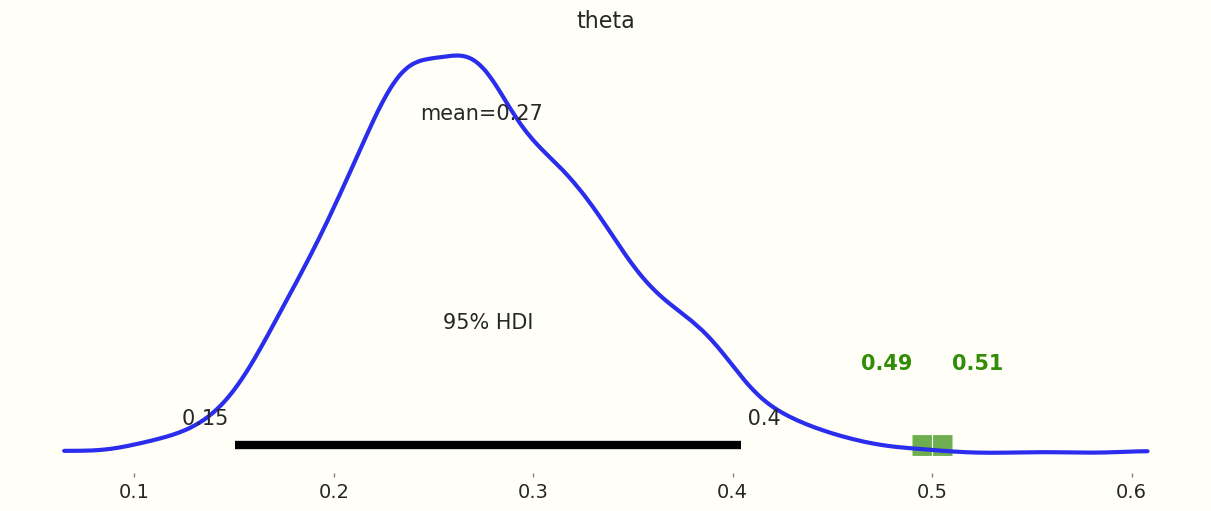

In [8]:
# showing both the 95% HDI and the rope
az.plot_posterior (trace, rope = [0.49, 0.51], hdi_prob=0.95);

# Comparing against a specific value

We can anyway compare the *posterior* with a reference value as follows:

* The plot reports the posterior mean, the probability of being smaller and larger than the reference value.

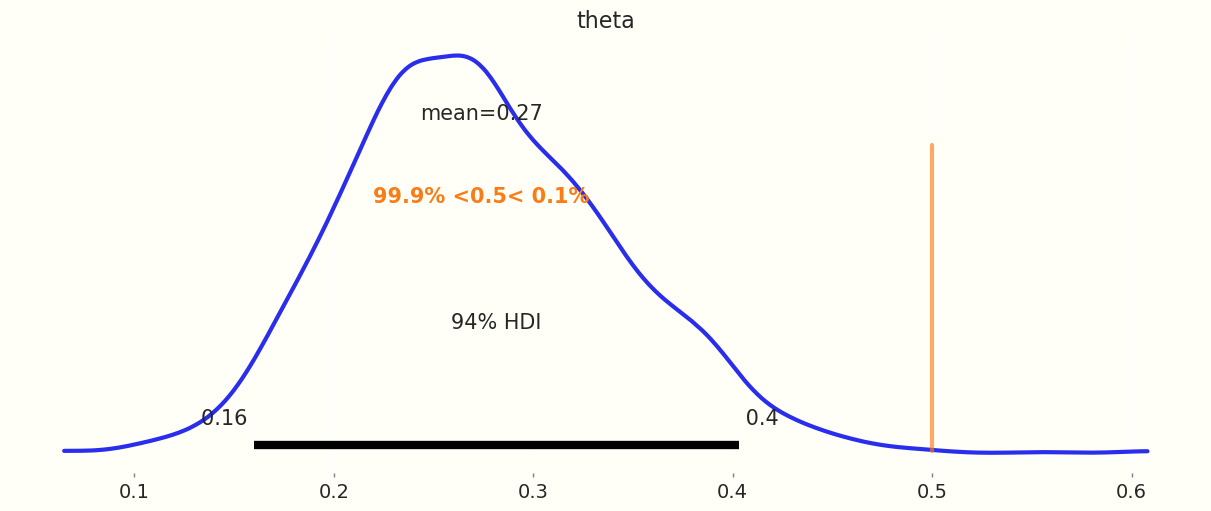

In [9]:
# the specific reference value (0.5) in this case rejected as it does not belong to the HDI.
# This is similar to a frequentist hypothesis test.
az.plot_posterior(trace, ref_val=0.5);